In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
%pip install tensorflow==2.17.0

In [1]:
#importing all the necessary modules
import os
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2.17.0


In [2]:
#defining some constants
IMAGE_SIZE= 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 70

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
#we are loading the dataset as a 4D Tensor, with shape [batch_size, height, width, channels].
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/leaf_images',
    shuffle = True,
    batch_size= BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
)

Found 9646 files belonging to 8 classes.


In [5]:
type(dataset)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
len(dataset) #number of batches

302

In [7]:
class_names = dataset.class_names #leaf diseases
# Get the number of images in each folder
image_counts = {class_name: len(os.listdir(os.path.join('/content/drive/MyDrive/leaf_images', class_name))) for class_name in class_names}

print("Class names and their corresponding integer labels:")
for index, class_name in enumerate(class_names):
    print(f"{index}: {class_name}")


Class names and their corresponding integer labels:
0: bacterial_blight
1: cercospora_leaf_blight
2: downey_mildew
3: frogeye
4: healthy
5: potassium_deficiency
6: soybean_rust
7: target_spot


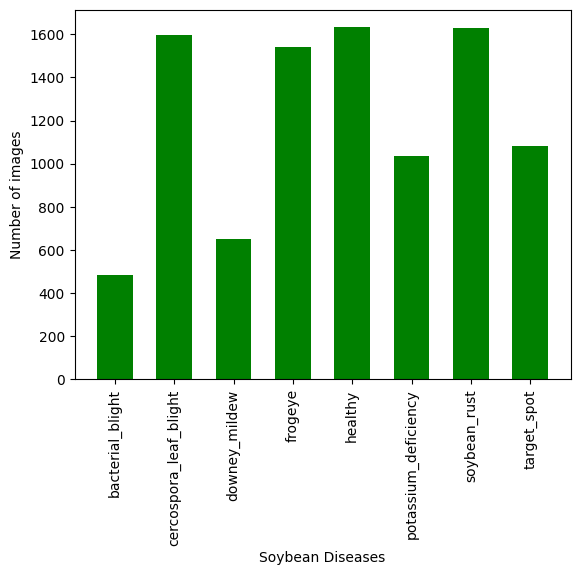

In [8]:
#plt.figure(figsize = (10,5))
plt.bar(list(image_counts.keys()), list(image_counts.values()), color = 'green', width = 0.6)
plt.xlabel("Soybean Diseases")
plt.ylabel("Number of images")
plt.xticks(rotation = 90)
plt.show()

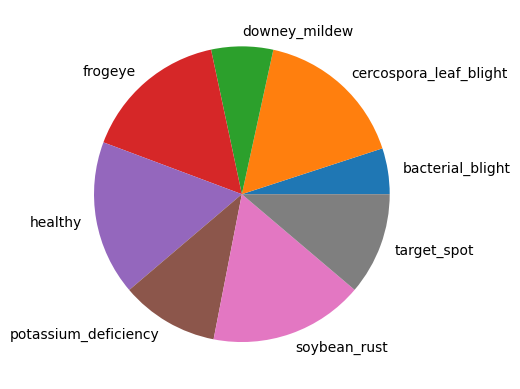

In [9]:
plt.pie(list(image_counts.values()), labels = list(image_counts.keys()))
plt.show()

In [10]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape) #shape of the batch of images, a 4D-Tensor
    print(label_batch.numpy()) #labels for our diseases, we convert the tensor into a numpy array
    print(type(label_batch))

(32, 224, 224, 3)
[1 2 5 7 1 6 4 4 6 2 7 4 7 3 3 4 2 4 4 3 1 7 2 5 6 1 0 3 5 7 7 0]
<class 'tensorflow.python.framework.ops.EagerTensor'>


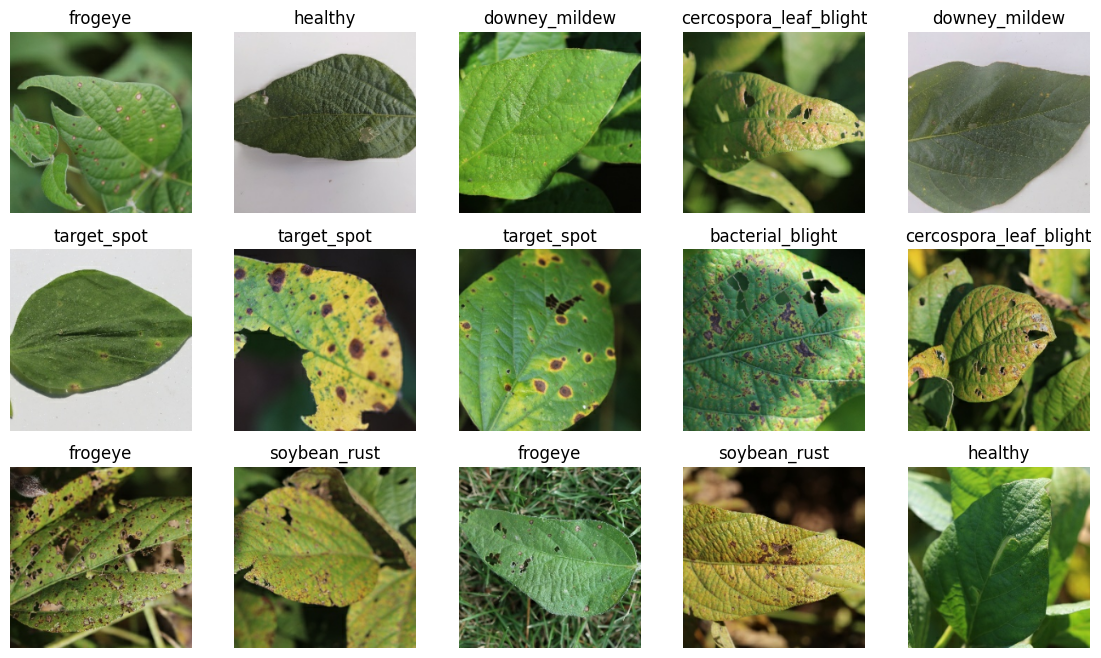

In [11]:
plt.figure(figsize = (14,8))
for batch_of_images, batch_of_labels in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i+1)
        plt.imshow(batch_of_images[i].numpy().astype('uint8')) #we convert the tensor into a numpy array of type 8 bit unsigned int
        plt.title(class_names[batch_of_labels[i]])
        plt.axis("off")

## Splitting the dataset

In [12]:
#we dont have train_test_split in tensors like we do in sci-kit learn, so we define our own function
def get_dataset_partitions_tf(ds, train_split = 0.7, valid_split = 0.15, test_split = 0.15, shuffle = True, shuffle_size = 10000):
    if shuffle:
        ds = ds.shuffle(shuffle_size) #you can also give a seed
    ds_size = len(ds)
    train_size = int(len(ds) * train_split)
    valid_size = int(len(ds) * valid_split)
    test_size = int(len(ds) * test_split)

    train_ds = ds.take(train_size)
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size + valid_size).take(test_size)

    return train_ds, valid_ds, test_ds

In [13]:
train_ds, valid_ds, test_ds = get_dataset_partitions_tf(dataset)
len(train_ds), len(valid_ds), len(test_ds)

(211, 45, 45)

In [14]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 224, 224, 3)
[7 4 7 3 1 6 7 3 7 3 4 0 5 2 2 2 4 4 1 0 3 7 1 3 1 4 1 4 6 4 5 3]


In [24]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze all layers of ResNet50
for layer in base_model.layers:
    layer.trainable = False
# Add custom layers on top of ResNet50
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Pooling the feature maps
x = layers.Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = layers.Dense(8, activation='softmax')(x)  # Final output layer with 8 classes

# Create the final model
model = models.Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/leaf_images',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)
'''

"\ntrain_datagen = ImageDataGenerator(\n    rescale=1./255,\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2,\n    horizontal_flip=True,\n    fill_mode='nearest'\n)\n\ntrain_generator = train_datagen.flow_from_directory(\n    '/content/drive/MyDrive/leaf_images',\n    target_size=(256, 256),\n    batch_size=32,\n    class_mode='categorical'\n)\n"

In [25]:
history = model.fit(train_ds, epochs=10, verbose=1, validation_data = valid_ds)


Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 160s 654ms/step - accuracy: 0.6596 - loss: 1.1749 - val_accuracy: 0.9028 - val_loss: 0.3094
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 150s 640ms/step - accuracy: 0.8820 - loss: 0.3334 - val_accuracy: 0.9125 - val_loss: 0.2301
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 149s 639ms/step - accuracy: 0.9171 - loss: 0.2339 - val_accuracy: 0.9417 - val_loss: 0.1795
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 150s 637ms/step - accuracy: 0.9355 - loss: 0.1928 - val_accuracy: 0.9604 - val_loss: 0.1108
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 152s 646ms/step - accuracy: 0.9495 - loss: 0.1460 - val_accuracy: 0.9632 - val_loss: 0.1159
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 151s 642ms/step - accuracy: 0.9646 - loss: 0.1029 - val_accuracy: 0.9486 - val_loss: 0.1374
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 152s 650ms/step - accuracy: 0.9652 - loss: 0.1011 - val_accuracy: 0.9618 - val_loss: 0.1296
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 150s 648ms/step - accuracy: 0.9705 -

In [ ]:
#lets define our preprocessing pipeline
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

In [20]:
#lets define our data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.2),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
    #layers.RandomTranslation
])

In [ ]:
#import tf_keras DO NOT EXECUTE OLD MODEL
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = tf.keras.Sequential([
    layers.Input(shape=input_shape),  # input_shape is deprecated
    # Our data augmentation and resizing and rescaling layers
    data_augmentation,
    resize_and_rescale,

    # Defining our convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Added dropout

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Added dropout

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.1),  # Added dropout

    layers.Flatten(),

    # Defining our dense layers
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),  # Added dropout before the output layer
    layers.Dense(n_classes, activation='softmax'),
])



In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             520 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 184,072 (719.03 KB)

 Trainable params: 184,072 (719.03 KB)

 Non-trainable params: 0 (0.00 B)

C:\Users\DELL\anaconda3\envs\soybean\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


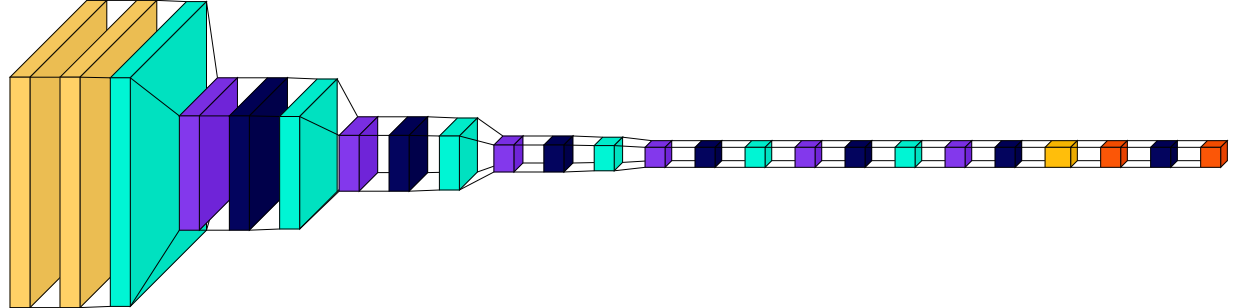

In [ ]:
import visualkeras
from collections import defaultdict
color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'

visualkeras.layered_view(model, spacing=30, color_map = color_map, scale_xy= 0.9)

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, restore_best_weights=True)

In [ ]:
history = model.fit(train_ds, epochs = EPOCHS,  batch_size = BATCH_SIZE, verbose = 1, validation_data = valid_ds)

Epoch 1/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 142s 628ms/step - accuracy: 0.1849 - loss: 2.2693 - val_accuracy: 0.3757 - val_loss: 1.8023
Epoch 2/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 134s 607ms/step - accuracy: 0.3503 - loss: 1.8138 - val_accuracy: 0.3854 - val_loss: 1.7167
Epoch 3/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 134s 606ms/step - accuracy: 0.3955 - loss: 1.6999 - val_accuracy: 0.4448 - val_loss: 1.5718
Epoch 4/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 135s 606ms/step - accuracy: 0.4383 - loss: 1.5790 - val_accuracy: 0.5021 - val_loss: 1.4359
Epoch 5/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 134s 607ms/step - accuracy: 0.4885 - loss: 1.4749 - val_accuracy: 0.5194 - val_loss: 1.3133
Epoch 6/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 133s 603ms/step - accuracy: 0.5157 - loss: 1.3923 - val_accuracy: 0.6021 - val_loss: 1.1466
Epoch 7/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 132s 608ms/step - accuracy: 0.5757 - loss: 1.2811 - val_accuracy: 0.6349 - val_loss: 1.1026
Epoch 8/70
193/193 ━━━━━━━━━━━━━━━━━━━━ 132s 599ms/step - accuracy: 0.5988 -

In [27]:
model.save('test_1_26_sept.keras')

In [26]:
scores = model.evaluate(test_ds)
scores

45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 488ms/step - accuracy: 0.9891 - loss: 0.0330


[0.028111208230257034, 0.9916666746139526]

In [28]:
accu = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation accuracy')

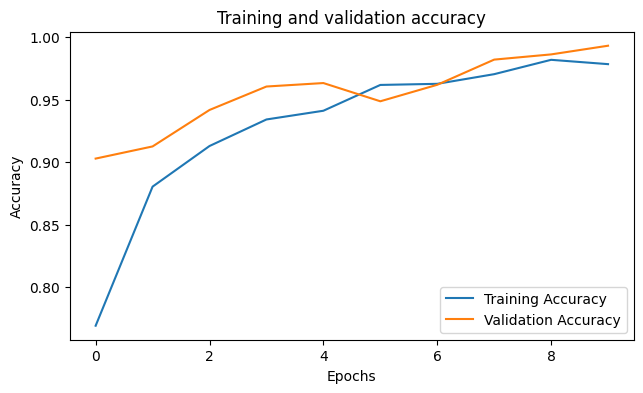

In [29]:
plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plt.plot( accu, label = 'Training Accuracy')
plt.plot( val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy")

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
# Evaluate your model on the test dataset
y_true = []
y_pred = []

# Assuming you have a test dataset
for x_batch, y_batch in test_ds:
    y_true.extend(y_batch.numpy())
    predictions = model.predict(x_batch)
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Convert lists to arrays for sklearn metrics
y_true = np.array(y_true)
y_pred = np.array(y_pred)
# Clear the output
clear_output(wait=True)
# Calculate Precision, Recall, and F1-Score
precision = precision_score(y_true, y_pred, average='weighted')  # or 'macro' for equal weight
recall = recall_score(y_true, y_pred, average='weighted')  # or 'macro'
f1 = f1_score(y_true, y_pred, average='weighted')  # or 'macro'

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')
print("Classification Report : ")
clf_report = classification_report(y_true, y_pred)
print(clf_report)

Precision: 0.9863
Recall: 0.9861
F1-Score: 0.9861
Classification Report : 
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        69
           1       0.98      1.00      0.99       236
           2       0.98      1.00      0.99        94
           3       0.97      1.00      0.98       219
           4       0.98      0.97      0.98       260
           5       1.00      0.98      0.99       156
           6       0.99      0.98      0.99       247
           7       1.00      0.98      0.99       159

    accuracy                           0.99      1440
   macro avg       0.99      0.99      0.99      1440
weighted avg       0.99      0.99      0.99      1440



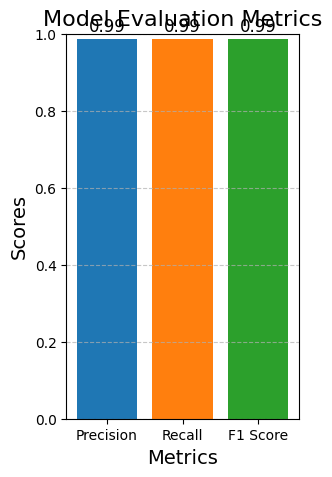

In [31]:
metrics = {
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Create lists for the bar chart
labels = list(metrics.keys())
values = list(metrics.values())

# Create a bar chart
plt.figure(figsize=(3, 5))
plt.bar(labels, values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])  # Custom colors for bars
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.title('Model Evaluation Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines for better readability

# Show the values on top of the bars
for i, value in enumerate(values):
    plt.text(i, value + 0.02, f'{value:.2f}', ha='center', fontsize=12)

plt.show()


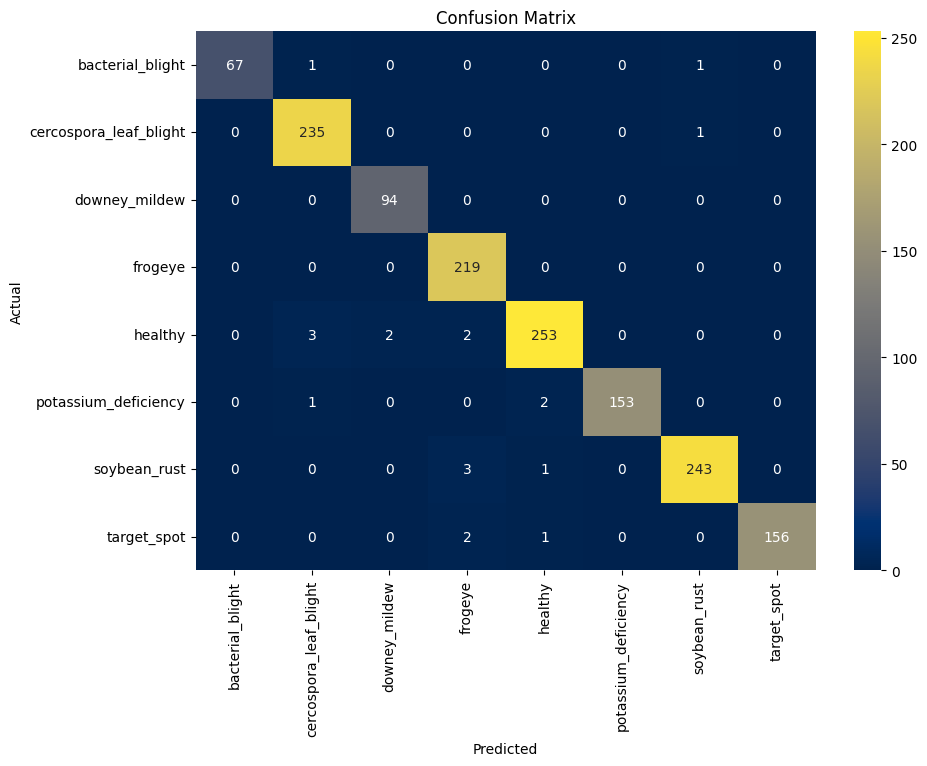

In [32]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis' , xticklabels = class_names, yticklabels =  class_names) # or use cmap = terrain
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

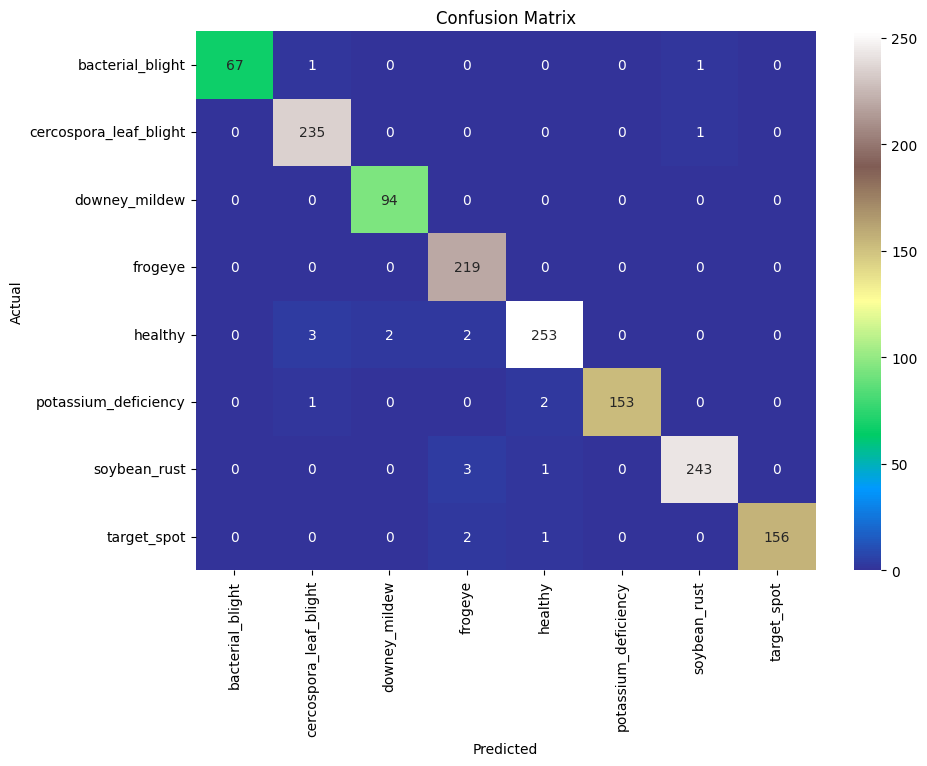

In [33]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='terrain' , xticklabels = class_names, yticklabels =  class_names) # or use cmap = terrain
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()